In [1]:
%matplotlib inline

import time

# math and data manipulation
import numpy as np
import pandas as pd
from tqdm import tqdm

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

from csef.model import lstm
from csef.data import preprocessing, load_data
from csef.utils import performance
from csef.model.base import BaseModel
from csef.model.base import GeneralModel

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data Loading

In [2]:
data_mapping = load_data.load_data()
consumption_train = data_mapping['consumption_train']
cold_start_test = data_mapping['cold_start_test']
submission_format = data_mapping['submission_format']
meta = data_mapping['meta']

## Training

In [3]:
load_data.describe_training_data(consumption_train)

There are 758 training series totaling 21224 days (509376 hours) of consumption data.


In [4]:
# Default config
n_batch = 1
n_input = 24
n_nodes = 24

### Release architect 001

In [5]:
batch_input_shape = (n_batch, 1, n_input)
config = {
    'n_input': n_input,
    'n_nodes': n_nodes,
    'n_batch': n_batch,
    'model': [
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': n_input,
                'batch_input_shape': batch_input_shape,
                'stateful': True
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': n_input,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dropout',
            'layer_config': {
                'rate': 0.01
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 12,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dropout',
            'layer_config': {
                'rate': 0.01
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 12,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dropout',
            'layer_config': {
                'rate': 0.01
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 6,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 1
            }
        }
    ]
}

In [6]:
model = GeneralModel(config)

In [7]:
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

total_start_time = time.time()

epoch_timers = []

for i in range(num_passes_through_data):
    epoch_start_time = time.time()
    model.fit(consumption_train)
    epoch_timers.append((epoch_start_time, time.time()))
    
total_end_time = time.time()

Fitting the data: 100%|██████████| 758/758 [31:04<00:00,  2.46s/it]


In [8]:
total_end_time - total_start_time

5589.7215077877045

In [9]:
epoch_timers

[(1539961189.5240922, 1539963051.4011917),
 (1539963051.401193, 1539964915.177256),
 (1539964915.1772573, 1539966779.2454407)]

## Make predict

In [11]:
my_submission = model.make_submission(submission_format, cold_start_test)

Forecasting from Cold Start Data: 100%|██████████| 625/625 [08:43<00:00,  1.16it/s]


In [12]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

count    5.808000e+03
mean     1.671020e+05
std      6.193105e+05
min     -9.135058e+01
25%      1.616238e+04
50%      3.652105e+04
75%      9.464016e+04
max      5.163810e+06
Name: consumption, dtype: float64

In [13]:
my_submission[my_submission.prediction_window == 'daily'].consumption.describe()

count    1.337000e+03
mean     3.418472e+06
std      1.001328e+07
min      4.082439e+03
25%      4.234891e+05
50%      8.957687e+05
75%      2.729480e+06
max      1.176524e+08
Name: consumption, dtype: float64

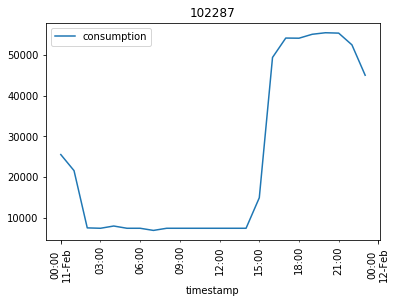

In [14]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [15]:
my_submission.head(20)

,series_id,timestamp,temperature,consumption,prediction_window
pred_id,,,,,
0,102781,2013-03-03,19.931250,3.729989e+05,daily
1,102781,2013-03-04,20.034375,3.729989e+05,daily
2,102781,2013-03-05,19.189583,3.729989e+05,daily
3,102781,2013-03-06,18.397917,3.729989e+05,daily
4,102781,2013-03-07,20.762500,3.729989e+05,daily
5,102781,2013-03-08,19.800000,3.729989e+05,daily
6,102781,2013-03-09,20.466667,3.729989e+05,daily
7,103342,2013-06-26,10.486607,1.204608e+07,weekly
8,103342,2013-07-03,10.006548,1.256478e+07,weekly


In [16]:
save_path = Path('..', '..', 'data', 'submissions')
save_path.mkdir(exist_ok=True, parents=True)
my_submission.to_csv(save_path / "release-001-20181019.csv", index_label='pred_id')

Submitted on 2018-10-19: 0.4970

In [24]:
model_path = Path('..', '..', 'data', 'model')
model_path.mkdir(exist_ok=True, parents=True)
keras.models.save_model(
    model.model,
    model_path / 'release-01-20181019.hdf5'
)